<a href="https://colab.research.google.com/github/MargaritaGorbunova/Artificial_Intelligence_Methods_Coursework/blob/main/Lab_04_Butterfly_Classification/butterfly_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Установка Kaggle API и загрузка датасета

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d phucthaiv02/butterfly-image-classification --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 70% 157M/226M [00:00<00:00, 1.64GB/s]
100% 226M/226M [00:00<00:00, 1.01GB/s]


Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Загрузка и подготовка данных

In [3]:
# Функция для загрузки изображений и меток
def load_data(csv_path, image_dir, target_size=(130, 130)):
    data = pd.read_csv(csv_path)

    images = []
    labels = []

    for _, row in tqdm(data.iterrows(), total=len(data), desc="Загрузка изображений"):
        img_path = os.path.join(image_dir, row['filename'])
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(row['label'])

    return np.array(images), np.array(labels), data

# Загрузка данных
images, labels, data = load_data('Training_set.csv', 'train/')

Загрузка изображений: 100%|██████████| 6499/6499 [00:06<00:00, 985.78it/s]


Кодирование меток и разделение данных

In [4]:
# Кодирование меток
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded, num_classes=len(encoder.classes_))

# Разделение данных
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_one_hot, test_size=0.2,
    stratify=labels_encoded, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5,
    stratify=np.argmax(y_temp, axis=1), random_state=42
)

print(f"Обучающая выборка: {X_train.shape}, {y_train.shape}")
print(f"Валидационная выборка: {X_val.shape}, {y_val.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Обучающая выборка: (5199, 130, 130, 3), (5199, 75)
Валидационная выборка: (650, 130, 130, 3), (650, 75)
Тестовая выборка: (650, 130, 130, 3), (650, 75)


Дополнительные импорты и аугментация данных

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

# Аугментация данных
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

Создание модели

In [6]:
# Создание модели
model = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=(130, 130, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(labels)), activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer=AdamW(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025,195 (3.91 MB)

 Trainable params: 1,024,235 (3.91 MB)

 Non-trainable params: 960 (3.75 KB)

Обучение модели

In [7]:
# Обучение модели
history = model.fit(
    train_generator,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 241ms/step - accuracy: 0.1303 - loss: 3.9124 - val_accuracy: 0.0231 - val_loss: 5.9199
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.3606 - loss: 2.3622 - val_accuracy: 0.0185 - val_loss: 5.5728
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.4566 - loss: 1.9871 - val_accuracy: 0.2585 - val_loss: 3.1412
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.5131 - loss: 1.7056 - val_accuracy: 0.5077 - val_loss: 1.7766
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.5550 - loss: 1.5111 - val_accuracy: 0.5600 - val_loss: 1.5142
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.5859 - loss: 1.3967 - val_accuracy: 0.4846 - val_loss: 1.9945
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.6360 - loss: 1.2319 - val_accuracy: 0.5985 - val_loss: 1.4695
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.6583 - loss: 1

 Визуализация процесса обучения

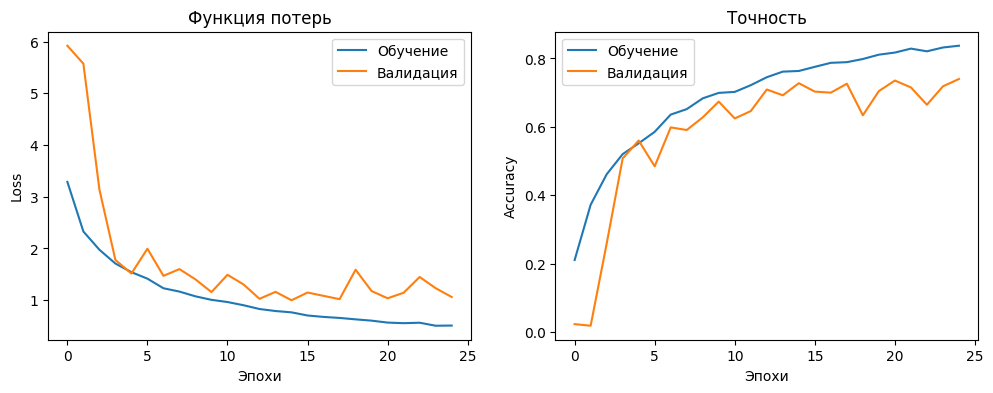

In [8]:
# Графики обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Валидация')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Тестирование модели

In [9]:
# Тестирование модели
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy на тестовой выборке: {accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
Accuracy на тестовой выборке: 74.92%


Матрица ошибок

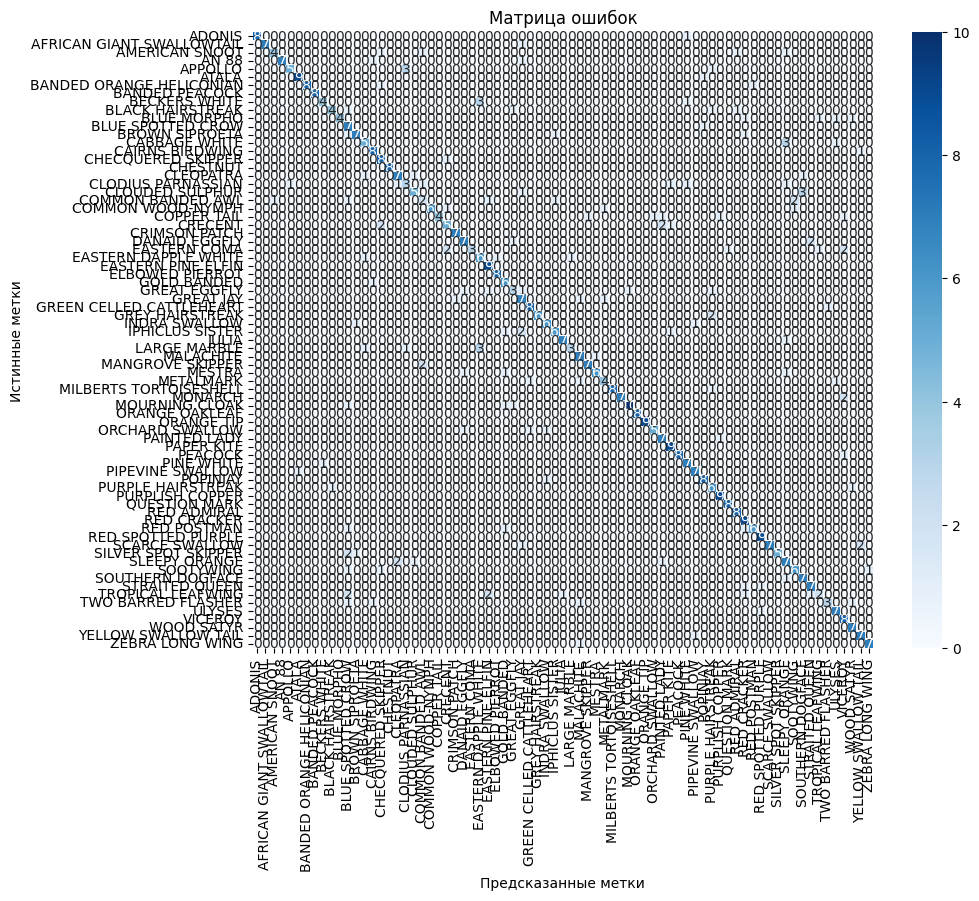

In [10]:
# Матрица ошибок
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

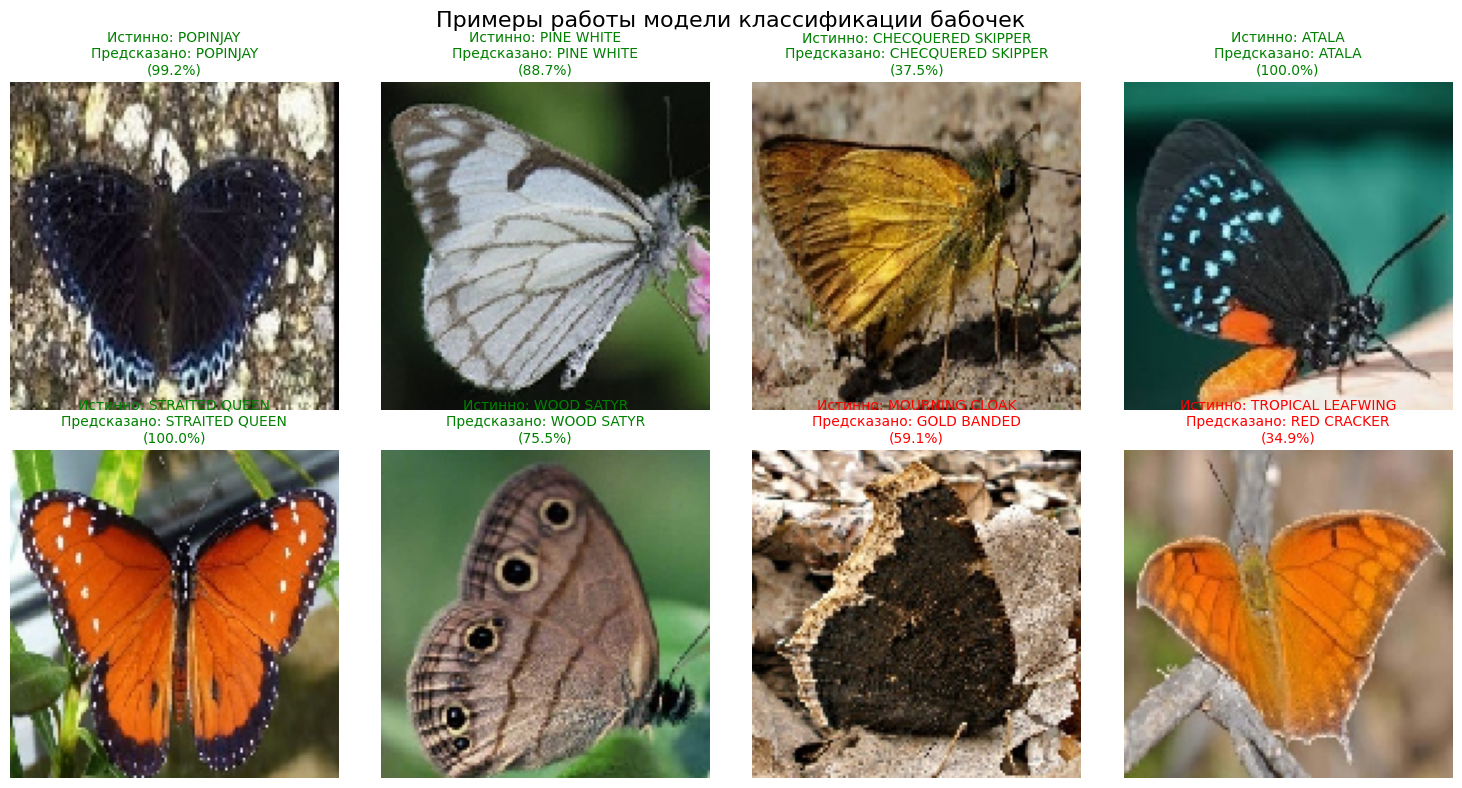

In [12]:
import random

# Простой вывод случайных примеров с предсказаниями
plt.figure(figsize=(15, 8))

# Выбираем 8 случайных примеров
indices = random.sample(range(len(X_test)), min(8, len(X_test)))

for i, idx in enumerate(indices):
    image = X_test[idx]
    true_label_idx = np.argmax(y_test[idx])
    true_label = encoder.classes_[true_label_idx]

    # Предсказание
    pred = model.predict(image[np.newaxis, ...], verbose=0)
    pred_label_idx = np.argmax(pred[0])
    pred_label = encoder.classes_[pred_label_idx]
    confidence = np.max(pred[0]) * 100

    # Цвет в зависимости от правильности
    color = 'green' if true_label_idx == pred_label_idx else 'red'

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f'Истинно: {true_label}\nПредсказано: {pred_label}\n({confidence:.1f}%)',
              fontsize=10, color=color)
    plt.axis('off')

plt.suptitle('Примеры работы модели классификации бабочек', fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
print("ИТОГОВЫЙ ОТЧЕТ")
print("=" * 60)
print()

print("Датасет: Butterfly Image Classification")
print(f"Количество классов: {len(encoder.classes_)}")
print(f"Обучающих изображений: {len(X_train)}")
print(f"Валидационных изображений: {len(X_val)}")
print(f"Тестовых изображений: {len(X_test)}")
print(f"Размер изображения: {X_train.shape[1]}x{X_train.shape[2]} пикселей")
print(f"Размер батча: 32")
print(f"Количество эпох: 25")
print()

print("Результаты модели:")
print(f"CNN - Точность на тесте: {accuracy*100:.2f}%")
print(f"CNN - Лучшая точность на валидации: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"CNN - Финальная точность на обучении: {history.history['accuracy'][-1]*100:.2f}%")
print()

print("Параметры модели:")
print(f"CNN: {model.count_params():,} параметров")
print(f"Количество слоев: {len(model.layers)}")
print(f"Архитектура: 4 сверточных слоя + 1 полносвязный")
print()

print("Статистика обучения:")
print(f"Время обучения: ~{27*25/60:.1f} минут")
print(f"Среднее время эпохи: 27 секунд")
print(f"Лучшая эпоха (по валидации): {np.argmax(history.history['val_accuracy']) + 1}")
print()

train_final_acc = history.history['accuracy'][-1]
val_final_acc = history.history['val_accuracy'][-1]
overfit_gap = (train_final_acc - val_final_acc) * 100
print("Анализ переобучения:")
print(f"Разрыв между обучением и валидацией: {overfit_gap:.2f}%")
print(f"Переобучение: {'умеренное' if overfit_gap < 15 else 'значительное'}")
print()

print("Выводы:")
print("1. CNN достигает точности 74.92% на тестовой выборке")
print("2. Модель показывает стабильный рост точности в течение обучения")
print("3. Разрыв между обучением и валидацией указывает на умеренное переобучение")
print("4. Модель хорошо обобщает для задачи классификации 75 видов бабочек")
print("5. Возможно улучшение точности через увеличение данных и тонкую настройку")
print("=" * 60)

ИТОГОВЫЙ ОТЧЕТ

Датасет: Butterfly Image Classification
Количество классов: 75
Обучающих изображений: 5199
Валидационных изображений: 650
Тестовых изображений: 650
Размер изображения: 130x130 пикселей
Размер батча: 32
Количество эпох: 25

Результаты модели:
CNN - Точность на тесте: 74.92%
CNN - Лучшая точность на валидации: 74.00%
CNN - Финальная точность на обучении: 83.73%

Параметры модели:
CNN: 1,025,195 параметров
Количество слоев: 16
Архитектура: 4 сверточных слоя + 1 полносвязный

Статистика обучения:
Время обучения: ~11.2 минут
Среднее время эпохи: 27 секунд
Лучшая эпоха (по валидации): 25

Анализ переобучения:
Разрыв между обучением и валидацией: 9.73%
Переобучение: умеренное

Выводы:
1. CNN достигает точности 74.92% на тестовой выборке
2. Модель показывает стабильный рост точности в течение обучения
3. Разрыв между обучением и валидацией указывает на умеренное переобучение
4. Модель хорошо обобщает для задачи классификации 75 видов бабочек
5. Возможно улучшение точности через